#**Loading and Exploring the Dataset**



In [6]:
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load the datasets
location_data = pd.read_csv('/content/drive/MyDrive/locationData.csv')
weather_data = pd.read_csv('/content/drive/MyDrive/weatherData.csv')

# Display the first few rows of each dataset
print(location_data.head())
print(weather_data.head())

   location_id  latitude  longitude  elevation  utc_offset_seconds  \
0            0  6.924429   79.90725          4               19800   
1            1  7.065026   79.96622         19               19800   
2            2  6.572935   80.02519          5               19800   
3            3  7.275923   80.62659        499               19800   
4            4  7.486819   80.52632        362               19800   

       timezone  timezone_abbreviation city_name  
0  Asia/Colombo                    530   Colombo  
1  Asia/Colombo                    530   Gampaha  
2  Asia/Colombo                    530  Kalutara  
3  Asia/Colombo                    530     Kandy  
4  Asia/Colombo                    530    Matale  
   location_id      date  weather_code (wmo code)  temperature_2m_max (°C)  \
0            0  1/1/2010                        1                     30.1   
1            0  1/2/2010                       51                     30.1   
2            0  1/3/2010               

#**Data visualization**

###**Line Plot for Temperature Over Time**

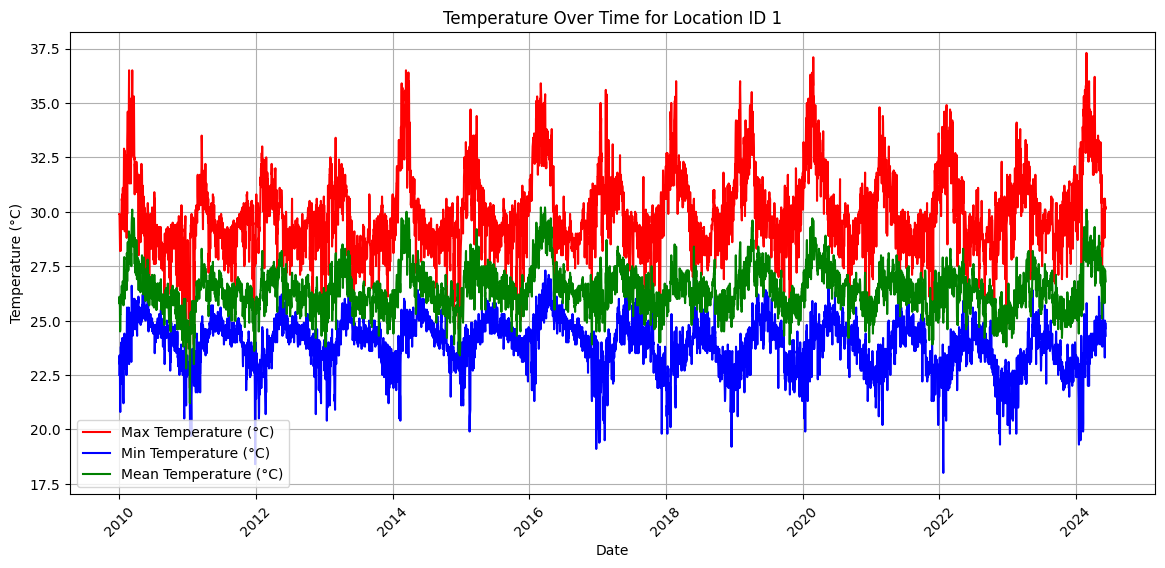

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the weather data
weather_data['date'] = pd.to_datetime(weather_data['date'])  # Convert date column to datetime

# Plotting the temperature data for a specific location (e.g., location_id = 1)
specific_location_id = 1  # Change this to the desired location ID
location_data = weather_data[weather_data['location_id'] == specific_location_id]

plt.figure(figsize=(14, 6))
plt.plot(location_data['date'], location_data['temperature_2m_max (°C)'], label='Max Temperature (°C)', color='red')
plt.plot(location_data['date'], location_data['temperature_2m_min (°C)'], label='Min Temperature (°C)', color='blue')
plt.plot(location_data['date'], location_data['temperature_2m_mean (°C)'], label='Mean Temperature (°C)', color='green')
plt.title('Temperature Over Time for Location ID {}'.format(specific_location_id))
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

###**Bar Plot for Precipitation**

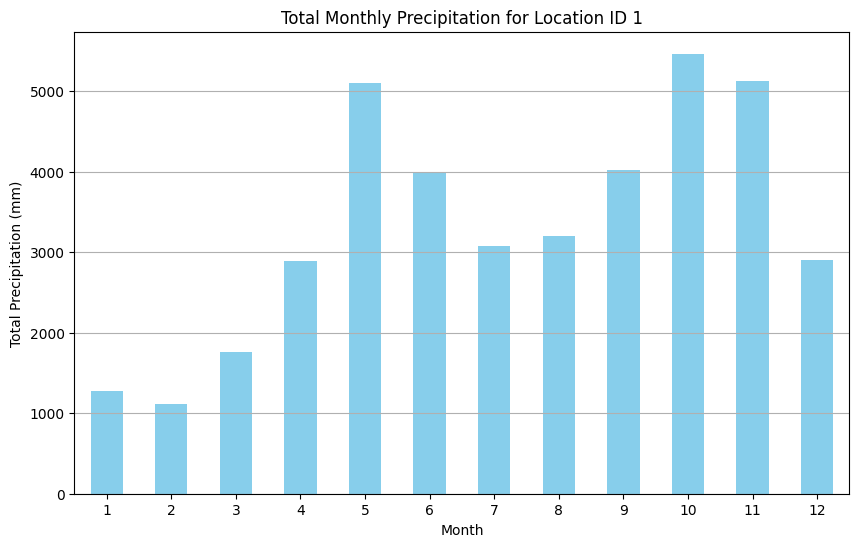

In [43]:
# Add a 'month' column for grouping by month
weather_data['month'] = weather_data['date'].dt.month

# Group by month and sum the precipitation for a specific location
monthly_precipitation = weather_data[weather_data['location_id'] == specific_location_id].groupby('month')['precipitation_sum (mm)'].sum()

plt.figure(figsize=(10, 6))
monthly_precipitation.plot(kind='bar', color='skyblue')
plt.title('Total Monthly Precipitation for Location ID {}'.format(specific_location_id))
plt.xlabel('Month')
plt.ylabel('Total Precipitation (mm)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

###**Scatter Plot for Temperature vs. Precipitation**

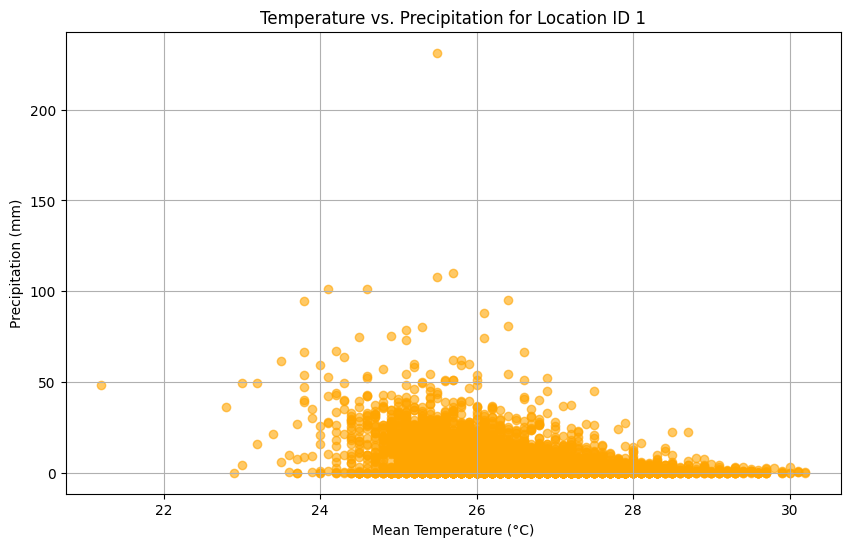

In [45]:
# Selecting a specific location for visualization
location_data = weather_data[weather_data['location_id'] == specific_location_id]

plt.figure(figsize=(10, 6))
plt.scatter(location_data['temperature_2m_mean (°C)'], location_data['precipitation_sum (mm)'], alpha=0.6, color='orange')
plt.title('Temperature vs. Precipitation for Location ID {}'.format(specific_location_id))
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.grid()
plt.show()

#**Data Preprocessing**

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [9]:
# Handling missing values (example: forward fill)
weather_data.fillna(method='ffill', inplace=True)

<ipython-input-9-0873df7560d0>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)


In [17]:
# Feature selection (assuming temperature and time are columns)
features = weather_data[['temperature_2m_mean (°C)',
                         'daylight_duration (s)',
                         'precipitation_sum (mm)',
                         'wind_speed_10m_max (km/h)',
                         'sunshine_duration (s)',
                         'apparent_temperature_mean (°C)']]

In [19]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)


# Reshaping for CNN (timesteps, features)
timesteps = 30  # Example: 30 time steps for past data
X, y = [], []

for i in range(timesteps, len(scaled_data)):
    X.append(scaled_data[i-timesteps:i])
    y.append(scaled_data[i, 0])  # Assuming temperature is the target

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

#**Model Architecture**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout

In [21]:
# Define the CNN model
model = Sequential()

# Adding convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Flatten())

# Adding dense layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for temperature prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#**Training the Model**

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0092 - val_loss: 0.0010
Epoch 2/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.0014 - val_loss: 7.6211e-04
Epoch 3/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0012 - val_loss: 7.8266e-04
Epoch 4/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0011 - val_loss: 6.3471e-04
Epoch 5/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.0011 - val_loss: 6.3475e-04
Epoch 6/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0011 - val_loss: 6.5038e-04
Epoch 7/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0011 - val_loss: 5.9294e-04
Epoch 8/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0011 - val_loss: 6.2919e-04
Epoch 9/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0011 - val_loss: 6.0693e-04
Epoch 10/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0011 - val_loss: 7.9178e-04
Epoch 11/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0011 - 

#**Model Evaluation**

In [24]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7116e-04
Test Loss (MSE): 0.0005831700400449336


In [26]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2}")

R² Score: 0.9722155564800796


#**Making Predictions**

In [28]:
# Create a dummy array for inverse transformation
dummy_pred = np.zeros((predictions.shape[0], scaled_data.shape[1]))  # Same number of features as original
dummy_pred[:, 0] = predictions[:, 0]  # Place predictions in the first column (assuming temperature is in the first column)

# Inverse transform only the temperature column
predictions = scaler.inverse_transform(dummy_pred)[:, 0]

# Do the same for y_test to bring it back to the original scale
dummy_test = np.zeros((y_test.shape[0], scaled_data.shape[1]))
dummy_test[:, 0] = y_test
y_test = scaler.inverse_transform(dummy_test)[:, 0]

# Display some predictions vs actual values
for i in range(10):
    print(f"Predicted: {predictions[i]}, Actual: {y_test[i]}")

Predicted: 23.85965518951416, Actual: 24.5
Predicted: 26.482213723659516, Actual: 26.4
Predicted: 27.32733942270279, Actual: 26.6
Predicted: 28.20578052997589, Actual: 27.9
Predicted: 26.409613072872162, Actual: 25.7
Predicted: 23.54417117834091, Actual: 22.599999999999998
Predicted: 16.263122045993804, Actual: 15.8
Predicted: 26.628377664089204, Actual: 26.6
Predicted: 27.223203754425047, Actual: 26.6
Predicted: 29.437022638320922, Actual: 29.5
